<a href="https://colab.research.google.com/github/runningman145/Food-Quality-Assesment/blob/main/Fruit_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Analyzing Class Distribution
2. Applying Noise Reduction
3. Balancing the dataset

In [ ]:
# import necessary libraries
import zipfile # for working with zipfiles
import os # for operating system related tasks like file and directory
import shutil # for high-level operations, copying and moving files
from collections import Counter # counting frequency of items in a list
import matplotlib.pyplot as plt # for data visualization
import cv2 # opencv for computer vision
import numpy as np
import random

# Step 1: Zip File Handling and Class Distribution Analysis

def extract_zip(zip_path, extract_path):
    """
      Extract the contents of the zip file to a specified path.
      Ensures the file is closed properly
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      # extracts to the specified path which is extract_path
        zip_ref.extractall(extract_path)

def analyze_class_distribution(dataset_path):
    """Analyzes the class distribution of images in the dataset."""
    class_counts = Counter()

    # Iterate through dictionaries and count images in each class of class_counts
    for root, dirs, files in os.walk(dataset_path):
        for dir in dirs:
            class_path = os.path.join(root, dir)
            class_counts[dir] = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    return class_counts


def plot_distribution(class_counts):
    """Plot the distribution of images across classes."""
    # Get keys and values from the class counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, counts)
    plt.title('Distribution of Images Across Fruit Categories')
    plt.xlabel('Fruit Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    # plt.close()

In [ ]:
# Step 2: Noise Reduction

def apply_noise_reduction(image_path, output_path, method='gaussian', kernel_size=5):
    """Apply noise reduction to a single image."""
    # Read the image
    img = cv2.imread(image_path)

    # applying noise reduction, gaussian noise reduction
    if method == 'gaussian':
        denoised = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    elif method == 'median':
        denoised = cv2.medianBlur(img, kernel_size)
    else:
        raise ValueError("Method must be 'gaussian' or 'median'")

    cv2.imwrite(output_path, denoised)

def process_dataset(input_dir, output_dir, method='gaussian', kernel_size=5):
    """Apply noise reduction to all images in the dataset."""
    # Iterate through all files and apply noise reduction
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, relative_path)

                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                apply_noise_reduction(input_path, output_path, method, kernel_size)


In [ ]:
# Step 3: Dataset Balancing

def balance_dataset(input_dir, output_dir, target_count=None):
    """
    Balance the dataset by oversampling minority classes.
    arguments:

    """
    class_counts = Counter()

    # Count the images in each class
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Determine the target count, the desired number of images per class
    if target_count is None:
        target_count = max(class_counts.values())

    # Balance classes
    for class_name, count in class_counts.items():
        input_class_path = os.path.join(input_dir, class_name)
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        # Copy all original images
        files = [f for f in os.listdir(input_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for file in files:
            shutil.copy2(os.path.join(input_class_path, file), output_class_path)

        # Oversample if necessary
        if count < target_count:
            for i in range(target_count - count):
                file = random.choice(files)
                new_name = f"{os.path.splitext(file)[0]}_copy{i}{os.path.splitext(file)[1]}"
                shutil.copy2(os.path.join(input_class_path, file),
                             os.path.join(output_class_path, new_name))

Extracting /content/archive.zip...
Analyzing class distribution...

Initial Class Distribution:
fruits-360_dataset_100x100: 0
fruits-360_dataset_original-size: 0
fruits-360: 0
Test: 0
Training: 0
Orange 1: 479
Corn Husk 1: 462
Kumquats 1: 490
Pear 1: 492
Pear Stone 1: 711
Tomato 2: 672
Huckleberry 1: 490
Cherry Rainier 1: 738
Cocos 1: 490
Grape Blue 1: 984
Tomato 3: 738
Cucumber 1: 150
Cherry 1: 492
Granadilla 1: 490
Lemon Meyer 1: 490
Corn 1: 450
Apple Golden 3: 481
Banana Red 1: 490
Ginger Root 1: 297
Peach Flat 1: 492
Grape White 3: 492
Watermelon 1: 475
Tomato Maroon 1: 367
Pineapple Mini 1: 493
Nectarine 1: 492
Strawberry 1: 492
Peach 1: 492
Cucumber Ripe 1: 392
Mango Red 1: 426
Dates 1: 490
Banana Lady Finger 1: 450
Avocado ripe 1: 491
Mulberry 1: 492
Zucchini dark 1: 240
Tomato Heart 1: 684
Apple Pink Lady 1: 456
Apple 6: 473
Pomegranate 1: 492
Grape White 4: 471
Grape White 1: 490
Apple Red 3: 429
Apple Crimson Snow 1: 444
Pomelo Sweetie 1: 450
Salak 1: 490
Clementine 1: 490
Wa

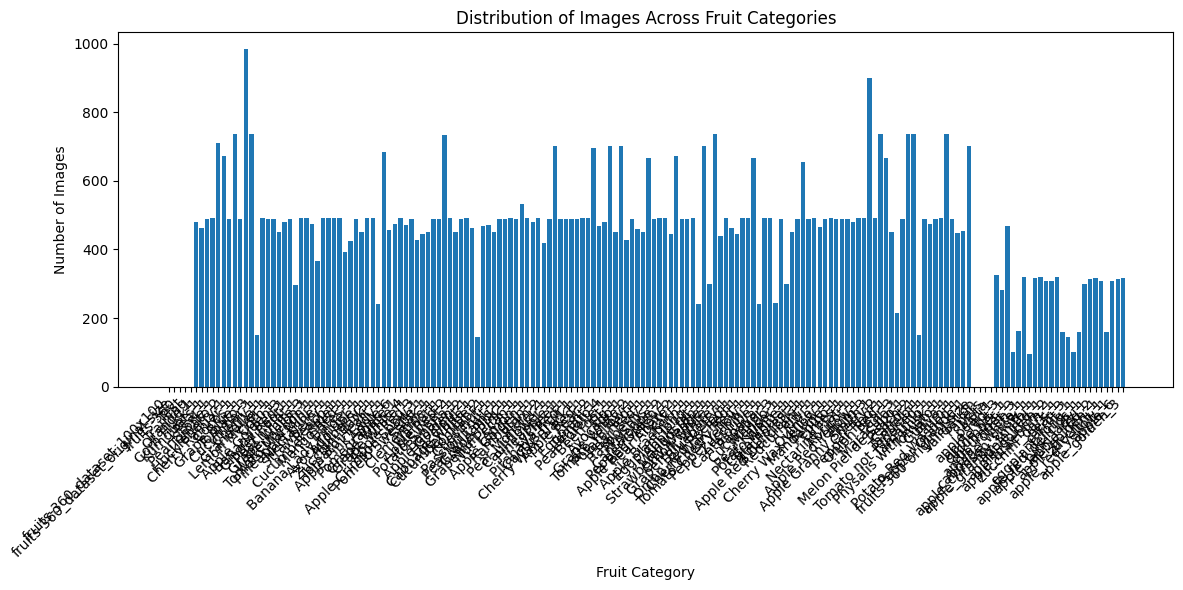

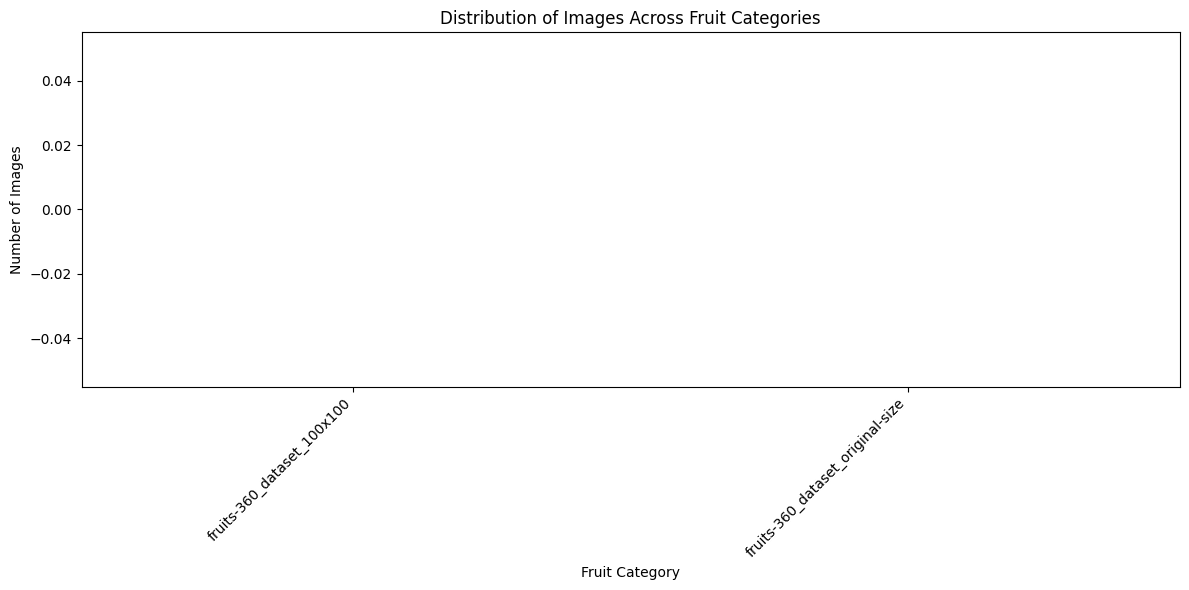

In [ ]:
# Main workflow

def main(zip_path):
    # Creating temporary directories
    temp_dir = "temp_extracted_dataset"
    denoised_dir = "temp_denoised_dataset"
    balanced_dir = "balanced_dataset"
    os.makedirs(temp_dir, exist_ok=True)
    os.makedirs(denoised_dir, exist_ok=True)
    os.makedirs(balanced_dir, exist_ok=True)

    try:
        # Step 1: Extract and Analyze
        print(f"Extracting {zip_path}...")
        extract_zip(zip_path, temp_dir)

        print("Analyzing class distribution...")
        class_counts = analyze_class_distribution(temp_dir)

        print("\nInitial Class Distribution:")
        for class_name, count in class_counts.items():
            print(f"{class_name}: {count}")

        plot_distribution(class_counts)
        print("Initial distribution plot saved as 'class_distribution.png'")

        # Step 2: Noise Reduction
        print("\nApplying noise reduction...")
        process_dataset(temp_dir, denoised_dir, method='gaussian', kernel_size=5)

        # Step 3: Balance Dataset
        print("\nBalancing dataset...")
        balance_dataset(denoised_dir, balanced_dir)

        # Analyze final distribution
        final_class_counts = analyze_class_distribution(balanced_dir)
        print("\nFinal Class Distribution:")
        for class_name, count in final_class_counts.items():
            print(f"{class_name}: {count}")

        plot_distribution(final_class_counts)
        print("Final distribution plot saved as 'final_class_distribution.png'")

    finally:
        # Clean up temporary directories
        print("\nCleaning up temporary files...")
        shutil.rmtree(temp_dir)
        shutil.rmtree(denoised_dir)

    print(f"\nProcessing complete. Balanced dataset saved in '{balanced_dir}'")

if __name__ == "__main__":
    zip_path = "/content/archive.zip"  # Replace with your zip file path
    main(zip_path)